In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [44]:
mb_size = 64 # batch size
Z_dim = 256
X_dim = 1
i_dim = 1

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [52]:
""" Discriminator Net model """
h_dim = 128

X = tf.placeholder(tf.float32, shape=[None, X_dim + 1])
ind = tf.placeholder(tf.float32, shape=[None, i_dim])
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

D_W1 = tf.Variable(xavier_init([X_dim + 1 + i_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

def discriminator(x, ind):
    inputs = tf.concat(axis=1, values=[x, ind])
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [56]:
""" Generator Net model """
h_dim_1 = 256
h_dim_2 = 128
h_dim_3 = 64

G_W0 = tf.Variable(xavier_init([Z_dim, h_dim_1]))
G_b0 = tf.Variable(tf.zeros(shape=[h_dim_1]))
G_W1 = tf.Variable(xavier_init([h_dim_1, X_dim ]))
G_b1 = tf.Variable(tf.zeros(shape=[X_dim]))

# latent net weights and biases
G_W2_latent = tf.Variable(xavier_init([X_dim + i_dim, h_dim_2]))
G_b2_latent = tf.Variable(tf.zeros(shape=[h_dim_2]))
G_W3_latent = tf.Variable(xavier_init([h_dim_2, h_dim_3]))
G_b3_latent = tf.Variable(tf.zeros(shape=[h_dim_3]))
G_W4_latent = tf.Variable(xavier_init([h_dim_3, 1]))
G_b4_latent = tf.Variable(tf.zeros(shape=[1]))

# censor net weights and biases
G_W2_censor = tf.Variable(xavier_init([X_dim + i_dim, h_dim_2]))
G_b2_censor = tf.Variable(tf.zeros(shape=[h_dim_2]))
G_W3_censor = tf.Variable(xavier_init([h_dim_2, h_dim_3]))
G_b3_censor = tf.Variable(tf.zeros(shape=[h_dim_3]))
G_W4_censor = tf.Variable(xavier_init([h_dim_3, 1]))
G_b4_censor = tf.Variable(tf.zeros(shape=[1]))

theta_G = [G_W0, G_W1, \
           G_b0, G_b1, \
           G_W2_latent, G_W3_latent, G_W4_latent, \
           G_b2_latent, G_b3_latent, G_b4_latent, \
           G_W2_censor, G_W3_censor, G_W4_censor, \
           G_b2_censor, G_b3_censor, G_b4_censor]

def generator(z, ind):
    G_x = tf.matmul(tf.nn.relu(tf.matmul(z, G_W0) + G_b0), G_W1) + G_b1 # X_dim
    G_x_ind = tf.concat(axis=1, values=[G_x, ind])
    
    G_h_latent = tf.nn.relu(tf.matmul(G_x_ind, G_W2_latent) + G_b2_latent)
    G_h_censor = tf.nn.relu(tf.matmul(G_x_ind, G_W2_censor) + G_b2_censor)
    
    G_h2_latent = tf.nn.relu(tf.matmul(G_h_latent, G_W3_latent) + G_b3_latent)
    G_h2_censor = tf.nn.relu(tf.matmul(G_h_censor, G_W3_censor) + G_b3_censor)
    
    G_t = tf.matmul(G_h2_latent, G_W4_latent) + G_b4_latent
    G_c = tf.matmul(G_h2_censor, G_W4_censor) + G_b4_censor
    
    G_y = tf.maximum(G_t, G_c) # left censoring
    
    G_prob = tf.concat([G_x, G_y], axis=1)

    return G_prob

In [57]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

In [58]:
G_sample = generator(Z, ind)
D_real, D_logit_real = discriminator(X, ind)
D_fake, D_logit_fake = discriminator(G_sample, ind)

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [157]:
def generate_real(m, d):
    x = np.random.uniform(-1., 1., size=[m, d])
    t = np.sum(x**2, axis=1, keepdims=True)
    c = np.sum(x**2, axis=1, keepdims=True) + 0.5*np.sin(8*np.pi*x)
    y = np.maximum(t,c) # left censoring
    ind = np.argmax([c,t], axis=0) # indicator of censoring
    return np.concatenate((x,y), axis=1), ind

In [158]:
import operator
T = generate_real(2000, X_dim)
x = T[0][:,:-1]
y = T[0][:,-1]
i = T[1]
L = sorted(zip(x,y), key=operator.itemgetter(0))
x, y = zip(*L)
x = np.array(x)
y = np.array(y)

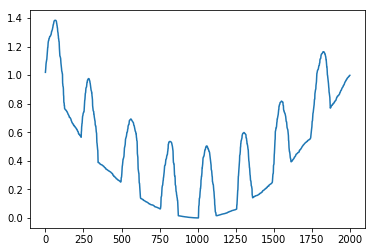

In [159]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(y)

In [160]:
D = 1
G = 1
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for it in range(50001):
    
    for d in range(D):
        X_mb, ind_mb = generate_real(mb_size, X_dim)
        Z_sample = sample_Z(mb_size, Z_dim)
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_sample, ind:ind_mb})
        
    for g in range(G):
        _, ind_mb = generate_real(mb_size, X_dim)
        Z_sample = sample_Z(mb_size, Z_dim)
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_sample, ind:ind_mb})

    if D_loss_curr < 0.5:
        G = 10
    else:
        G = 1
        
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

Iter: 0
D loss: 1.385
G_loss: 0.7171

Iter: 1000
D loss: 1.397
G_loss: 0.7435

Iter: 2000
D loss: 1.637
G_loss: 0.5831

Iter: 3000
D loss: 1.144
G_loss: 1.325

Iter: 4000
D loss: 1.371
G_loss: 0.7271

Iter: 5000
D loss: 1.37
G_loss: 0.7201

Iter: 6000
D loss: 1.352
G_loss: 0.7533

Iter: 7000
D loss: 1.279
G_loss: 0.7665

Iter: 8000
D loss: 1.371
G_loss: 0.7616

Iter: 9000
D loss: 1.335
G_loss: 0.7699

Iter: 10000
D loss: 1.362
G_loss: 0.7098

Iter: 11000
D loss: 1.355
G_loss: 0.7031

Iter: 12000
D loss: 1.367
G_loss: 0.7324

Iter: 13000
D loss: 1.355
G_loss: 0.7306

Iter: 14000
D loss: 1.344
G_loss: 0.7479

Iter: 15000
D loss: 1.393
G_loss: 0.8263

Iter: 16000
D loss: 1.32
G_loss: 0.7482

Iter: 17000
D loss: 1.301
G_loss: 0.7981

Iter: 18000
D loss: 1.339
G_loss: 0.7496

Iter: 19000
D loss: 1.316
G_loss: 0.7228

Iter: 20000
D loss: 1.341
G_loss: 0.7525

Iter: 21000
D loss: 1.288
G_loss: 0.7481

Iter: 22000
D loss: 1.32
G_loss: 0.7502

Iter: 23000
D loss: 1.33
G_loss: 0.7507

Iter: 2400

In [1]:
# test
G_W2_latent_final = G_W2_latent.eval(sess)
G_b2_latent_final = G_b2_latent.eval(sess)
G_W3_latent_final = G_W3_latent.eval(sess)
G_b3_latent_final = G_b3_latent.eval(sess)
G_W4_latent_final = G_W4_latent.eval(sess)
G_b4_latent_final = G_b4_latent.eval(sess)

G_W2_censor_final = G_W2_censor.eval(sess)
G_b2_censor_final = G_b2_censor.eval(sess)
G_W3_censor_final = G_W3_censor.eval(sess)
G_b3_censor_final = G_b3_censor.eval(sess)
G_W4_censor_final = G_W4_censor.eval(sess)
G_b4_censor_final = G_b4_censor.eval(sess)

NameError: name 'G_W2_latent' is not defined

In [140]:
def reLu(x):
    return np.maximum(x,0)

x_latent = np.concatenate((x,np.ones_like(i)), axis=1)
pred = np.dot(reLu(np.dot(reLu(np.dot(x_latent, G_W2_latent_final) + G_b2_latent_final), G_W3_latent_final) \
                   + G_b3_latent_final), G_W4_latent_final) + G_b4_latent_final

x_censor = np.concatenate((x,np.zeros_like(i)), axis=1)
pred_c = np.dot(reLu(np.dot(reLu(np.dot(x_censor, G_W2_censor_final) + G_b2_censor_final), G_W3_censor_final) \
                     + G_b3_censor_final), G_W4_censor_final) + G_b4_censor_final

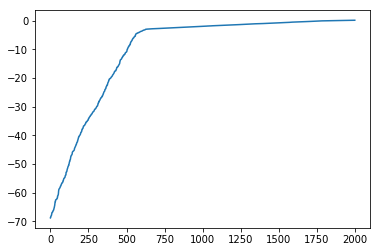

In [142]:
plt.plot(pred)

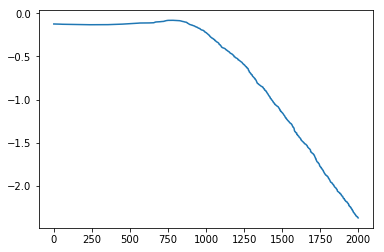

In [143]:
plt.plot(pred_c)

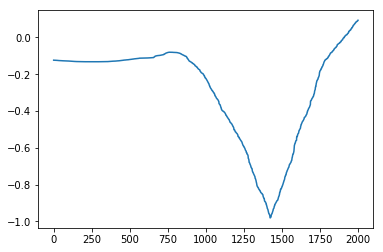

In [144]:
plt.plot(np.maximum(pred, pred_c))